In [1]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import dipy.data as dpd
import dipy.core.sphere as dps 
import dipy.sims as sims
import dipy.core.gradients as grad
import dipy.core.geometry as geo
import nibabel as nib


import scm.utils as ut
import scm.scm as scm

In [2]:
# 65 direction DTI data
fdata, fbval, fbvec = dpd.get_data()
gtab = grad.gradient_table(fbval, fbvec)
gtab.bvals = gtab.bvals # Make the units work out
data_ni = nib.load(fdata)
data = data_ni.get_data()

In [3]:
ni, gtab = dpd.read_stanford_hardi()

In [4]:
data = ni.get_data()

In [5]:
n_split = 75

In [6]:
data_train = np.concatenate([data[..., :5], data[..., 10:85]], -1)
data_test = np.concatenate([data[..., 5:10], data[..., 85:]], -1)

In [7]:
data_train.shape, data_test.shape

((81, 106, 76, 80), (81, 106, 76, 80))

In [8]:
gtab_train = grad.gradient_table_from_bvals_bvecs(np.concatenate([gtab.bvals[:5], gtab.bvals[10:85]]), 
                                                  np.concatenate([gtab.bvecs[:5], gtab.bvecs[10:85]]))

gtab_test = grad.gradient_table_from_bvals_bvecs(np.concatenate([gtab.bvals[5:10], gtab.bvals[85:]]), 
                                                 np.concatenate([gtab.bvecs[5:10], gtab.bvecs[85:]]))


In [9]:
sph1 = dpd.get_sphere()
#sph1 = dps.Sphere(xyz=[[1,0,0], [0,1,0], [0,0,1]])

In [10]:
dm_train = ut.design_matrix(gtab_train, sph1)

In [11]:
len(dm_train)

2025

In [12]:
alpha = 0.0001
l1_ratio = 0.8

In [13]:
reload(ut)

<module 'scm.utils' from '/Users/arokem/anaconda3/envs/py2/lib/python2.7/site-packages/scm/utils.py'>

In [14]:
dist_weights = ut.signal_weights(gtab_train) 
pp_sig = ut.preprocess_signal(data_train, gtab_train, 40, 40, 40, dist_weights=dist_weights)
sq_weights = dist_weights**2

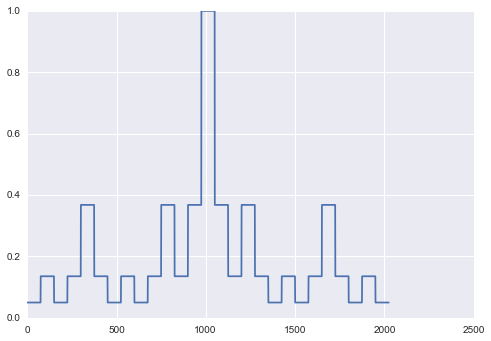

In [15]:
plt.plot(dist_weights)

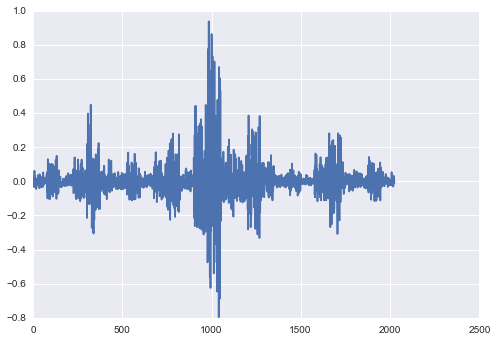

In [16]:
plt.plot(pp_sig)

In [17]:
new_dm = dm_train
new_sig = pp_sig

In [49]:
X = new_dm[n_split*13:n_split*14]
X_prime = new_dm[n_split*14:n_split*15]

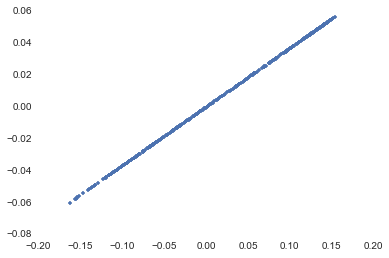

In [50]:
plt.plot(X[0], X_prime[0], '.')

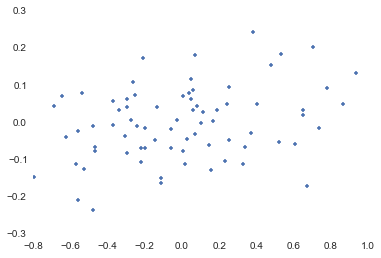

In [48]:
plt.plot(new_sig[n_split*13:n_split*14], new_sig[n_split*14:n_split*15], '.')

In [21]:
from sklearn.linear_model import ElasticNet

In [22]:
this_alpha = alpha * np.sum(sq_weights)/new_dm.shape[0]
EN = ElasticNet(alpha=this_alpha, l1_ratio=l1_ratio, positive=True)
beta = EN.fit(new_dm, new_sig).coef_
#beta, rnorm = opt.nnls(new_dm, new_sig)

/Users/arokem/anaconda3/envs/py2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:490: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


In [23]:
new_dm.shape, new_sig.shape

((2025, 362), (2025,))

In [24]:
y_hat = np.dot(new_dm, beta)

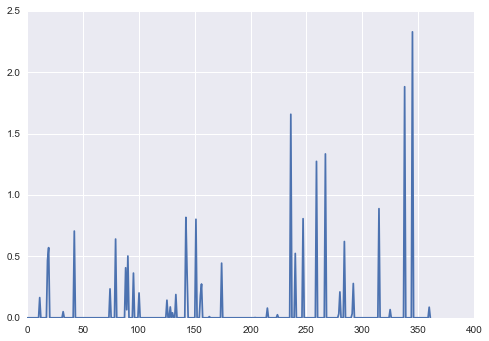

In [25]:
plt.plot(beta)

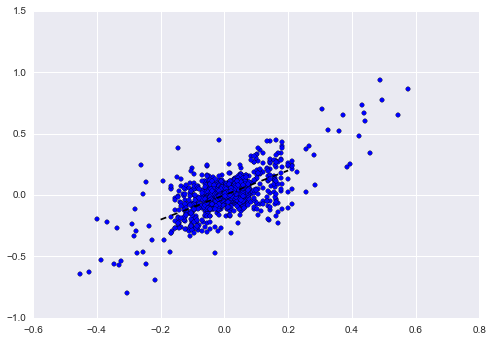

In [26]:
plt.scatter(y_hat, new_sig)
plt.plot([-0.2, 0.2], [-0.2, 0.2], 'k--')

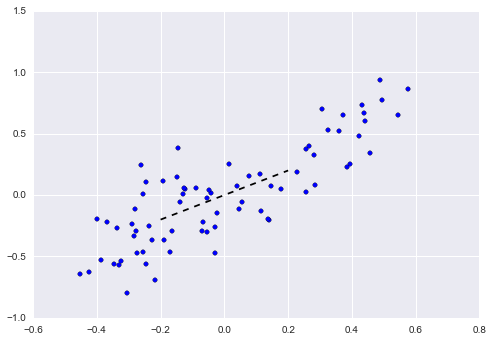

In [27]:
plt.scatter(y_hat[n_split*13:n_split*14], new_sig[n_split*13:n_split*14])
plt.plot([-0.2, 0.2], [-0.2, 0.2], 'k--')

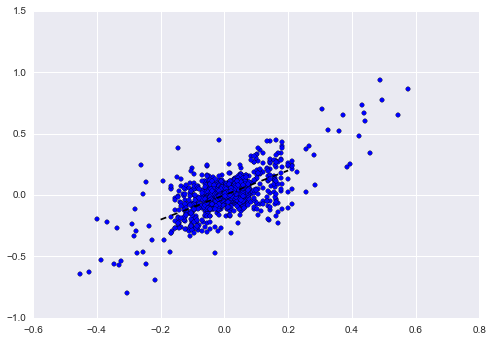

In [28]:
plt.scatter(y_hat[n_split:], new_sig[n_split:])
plt.plot([-0.2, 0.2], [-0.2, 0.2], 'k--')

In [29]:
#beta_non, rnorm = opt.nnls(new_dm[:n_split], new_sig[:n_split])
#beta_non, rnorm = opt.nnls(new_dm[:n_split], new_sig[:n_split])
EN = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, positive=True)
beta_non = EN.fit(new_dm[n_split*13:n_split*14], new_sig[n_split*13:n_split*14]).coef_


In [30]:
y_hat_non = np.dot(new_dm, beta_non)

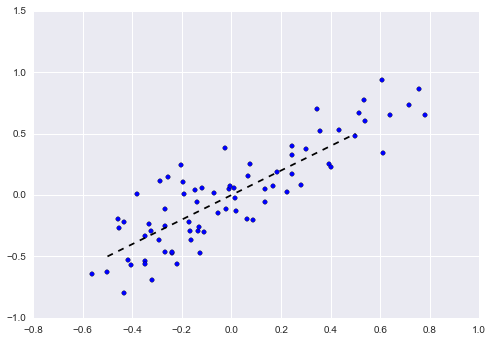

In [31]:
plt.scatter(y_hat_non[n_split*13:n_split*14], new_sig[n_split*13:n_split*14])
plt.plot([-0.5, 0.5], [-0.5, 0.5], 'k--')

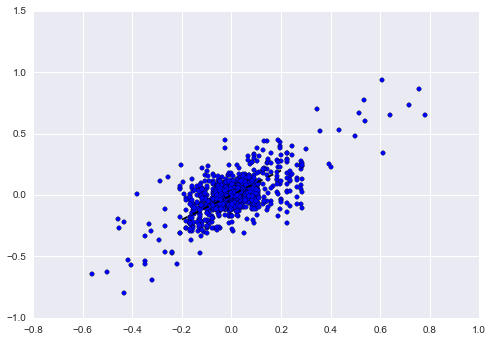

In [32]:
plt.scatter(y_hat_non[n_split:], new_sig[n_split:])
plt.plot([-0.2, 0.2], [-0.2, 0.2], 'k--')

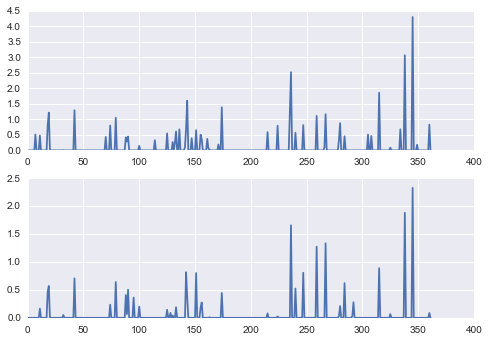

In [33]:
fig, ax = plt.subplots(2)
ax[0].plot(beta_non)
ax[1].plot(beta)

In [34]:
import dipy.viz.projections as proj
reload(proj)

<module 'dipy.viz.projections' from '/Users/arokem/anaconda3/envs/py2/lib/python2.7/site-packages/dipy/viz/projections.pyc'>

In [35]:
%matplotlib inline

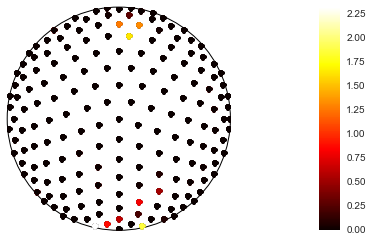

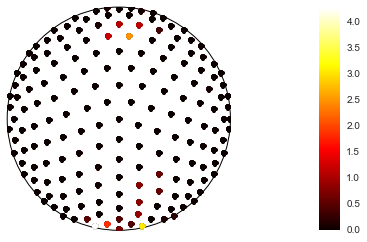

In [36]:
proj.sph_project(sph1.vertices.T, beta) 
proj.sph_project(sph1.vertices.T, beta_non) 


In [37]:
np.dot(beta_non, beta_non), np.dot(beta, beta)

(60.887876556943695, 21.336361847368014)

In [38]:
(np.sqrt(np.mean( (y_hat_non[n_split*13:n_split*14]- new_sig[n_split*13:n_split*14]) ** 2))/
np.sqrt(np.mean( (new_sig[n_split*13:n_split*14] - y_hat[n_split*13:n_split*14])**2 ) ))

0.87603827351112529

In [39]:
dm_test = ut.design_matrix(gtab_test, sph1)

In [40]:
y_hat_test = np.dot(dm_test, beta)
y_hat_non_test = np.dot(dm_test, beta_non)

In [41]:
dist_weights = ut.signal_weights(gtab_test) 
sig_test = ut.preprocess_signal(data_test, gtab_test, 40, 40, 40, dist_weights=dist_weights)
sq_weights = dist_weights**2

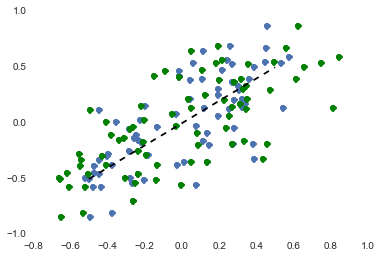

In [42]:
plt.plot(y_hat_test[n_split*13:n_split*14], sig_test[n_split*13:n_split*14], 'o')
plt.plot(y_hat_non_test[n_split*13:n_split*14], sig_test[n_split*13:n_split*14], 'go')
plt.plot([-0.5, 0.5], [-0.5, 0.5], 'k--')

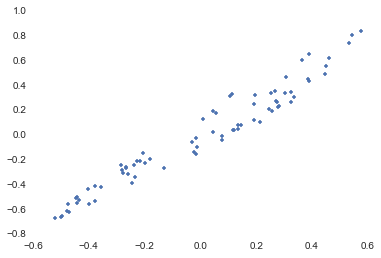

In [43]:
plt.plot(y_hat_test[n_split*13:n_split*14], y_hat_non_test[n_split*13:n_split*14], '.')

In [44]:
(np.sqrt(np.mean( (y_hat_non_test[n_split*13:n_split*14]- sig_test[n_split*13:n_split*14]) ** 2))/
np.sqrt(np.mean((sig_test[n_split*13:n_split*14] - y_hat_test[n_split*13:n_split*14])**2 )))

1.0689214054566569

In [45]:
import dipy.viz.fvtk as fvtk

In [46]:
def plot_peaks(beta, sphere, fname=None):
    idx = np.where(beta>0)
    peak_dirs = sphere.vertices[idx]
    peak_values = beta[idx]
    ren = fvtk.ren()
    beta_peaks = fvtk.peaks(peak_dirs, peak_values)
    fvtk.add(ren, beta_peaks)
    if fname is None:
        fvtk.show(ren)
    else:
        fvtk.record(ren, out_path=fname) 

In [47]:
#plot_peaks(beta, sph1, fname='./fig.png')
#!open fig.png